In [ ]:
# Cell 1: Install Required Dependencies
# ===============================================

!pip install kagglehub
!pip install opencv-python-headless
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install tensorflow
!pip install tqdm

print("✅ All dependencies installed successfully!")

✅ All dependencies installed successfully!


In [ ]:
# Cell 2: Import Libraries and Configuration
# ===============================================

import kagglehub
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import pandas as pd
import glob
import warnings
import gc
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
CONFIG = {
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 16,  # Reduced for Colab
    'EPOCHS': 15,      # Reduced for faster training
    'FINE_TUNE_EPOCHS': 10,
    'LEARNING_RATE': 0.001,
    'FINE_TUNE_LR': 0.0001,
    'TRAIN_SPLIT': 0.7,
    'VAL_SPLIT': 0.15,
    'TEST_SPLIT': 0.15,
    'PATIENCE': 5,
    'DISEASE_THRESHOLD': 0.1,
    'RANDOM_STATE': 42
}

# Paths
PATHS = {
    'BASE_DIR': '/content/tobacco_classification',
    'SOURCE_ROOT': None,
    'MERGED_ROOT': '/content/tobacco_classification/merged_data',
    'FINAL_ROOT': '/content/tobacco_classification/final_data',
    'MODELS_DIR': '/content/tobacco_classification/models',
    'RESULTS_DIR': '/content/tobacco_classification/results'
}

# Create directories
for path in PATHS.values():
    if path and path != PATHS['SOURCE_ROOT']:
        os.makedirs(path, exist_ok=True)

print("✅ Configuration and directories setup complete!")

✅ Configuration and directories setup complete!


In [ ]:
# Cell 3: Data Download and Safe File Operations
# ===============================================

def safe_copy_file(src, dst, max_retries=3):
    """Safely copy file with proper resource management"""
    for attempt in range(max_retries):
        try:
            # Ensure destination directory exists
            os.makedirs(os.path.dirname(dst), exist_ok=True)

            # Copy file with explicit resource management
            with open(src, 'rb') as fsrc:
                with open(dst, 'wb') as fdst:
                    shutil.copyfileobj(fsrc, fdst, 65536)  # 64KB chunks
            return True
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"❌ Failed to copy {src}: {e}")
                return False
            continue
    return False

def download_dataset():
    """Download tobacco leaf dataset from KaggleHub"""
    try:
        print("📥 Downloading tobacco leaf disease dataset...")
        path = kagglehub.dataset_download("chzili/dataset-for-tobacco-leaf-disease-segmentation")
        print(f"✅ Downloaded to: {path}")

        # List contents
        if os.path.exists(path):
            contents = os.listdir(path)
            print(f"📁 Contents: {contents}")
            return path
        else:
            print("❌ Download path not found")
            return None

    except Exception as e:
        print(f"❌ Error downloading dataset: {e}")
        return None

# Download dataset
source_path = download_dataset()
if source_path:
    PATHS['SOURCE_ROOT'] = source_path
    print(f"✅ Dataset ready at: {source_path}")
else:
    print("❌ Failed to download dataset")

print("✅ Data download setup complete!")

📥 Downloading tobacco leaf disease dataset...
✅ Downloaded to: /kaggle/input/dataset-for-tobacco-leaf-disease-segmentation
📁 Contents: ['data1', 'data2']
✅ Dataset ready at: /kaggle/input/dataset-for-tobacco-leaf-disease-segmentation
✅ Data download setup complete!


In [ ]:
# Cell 4: Data Processing Functions
# ===============================================

def is_diseased_mask(mask_path, threshold=CONFIG['DISEASE_THRESHOLD']):
    """Determine if a mask indicates disease based on non-black pixel ratio"""
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            return False

        non_black = cv2.countNonZero(mask)
        ratio = non_black / (mask.shape[0] * mask.shape[1])
        return ratio > threshold
    except Exception as e:
        return False

def process_dataset_batch(file_list, source_dir, target_healthy, target_diseased, batch_size=100):
    """Process files in batches to avoid memory issues"""
    healthy_count = 0
    diseased_count = 0
    error_count = 0

    for i in range(0, len(file_list), batch_size):
        batch = file_list[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(file_list)-1)//batch_size + 1}")

        for fname in tqdm(batch, desc=f"Batch {i//batch_size + 1}"):
            img_path = os.path.join(source_dir, "imgs", fname)
            mask_path = os.path.join(source_dir, "masks", fname)

            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            try:
                if is_diseased_mask(mask_path):
                    if safe_copy_file(img_path, os.path.join(target_diseased, fname)):
                        diseased_count += 1
                else:
                    if safe_copy_file(img_path, os.path.join(target_healthy, fname)):
                        healthy_count += 1
            except Exception as e:
                error_count += 1

        # Force garbage collection after each batch
        gc.collect()

    return healthy_count, diseased_count, error_count

def organize_tobacco_data(source_path):
    """Organize tobacco data with safe file handling"""
    print("🔄 Organizing tobacco leaf data...")

    # Create target directories
    healthy_dir = os.path.join(PATHS['MERGED_ROOT'], 'healthy')
    diseased_dir = os.path.join(PATHS['MERGED_ROOT'], 'diseased')
    os.makedirs(healthy_dir, exist_ok=True)
    os.makedirs(diseased_dir, exist_ok=True)

    total_healthy = 0
    total_diseased = 0
    total_errors = 0

    # Look for data directories
    data_dirs = []
    for root, dirs, files in os.walk(source_path):
        if 'imgs' in dirs and 'masks' in dirs:
            data_dirs.append(root)

    print(f"Found {len(data_dirs)} data directories")

    for data_dir in data_dirs:
        imgs_dir = os.path.join(data_dir, "imgs")

        if not os.path.exists(imgs_dir):
            continue

        print(f"📁 Processing {data_dir}...")
        image_files = [f for f in os.listdir(imgs_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            continue

        h_count, d_count, e_count = process_dataset_batch(
            image_files, data_dir, healthy_dir, diseased_dir
        )

        total_healthy += h_count
        total_diseased += d_count
        total_errors += e_count

    print(f"✅ Data organization complete!")
    print(f"   🌿 Healthy leaves: {total_healthy}")
    print(f"   🦠 Diseased leaves: {total_diseased}")
    print(f"   ❌ Errors: {total_errors}")

    return total_healthy, total_diseased

# Execute data organization
if PATHS['SOURCE_ROOT']:
    healthy_count, diseased_count = organize_tobacco_data(PATHS['SOURCE_ROOT'])
else:
    print("⚠️ No source data available")

print("✅ Data processing complete!")

🔄 Organizing tobacco leaf data...
Found 2 data directories
📁 Processing /kaggle/input/dataset-for-tobacco-leaf-disease-segmentation/data1/data1...
Processing batch 1/20


Batch 1: 100%|██████████| 100/100 [00:02<00:00, 41.55it/s]


Processing batch 2/20


Batch 2: 100%|██████████| 100/100 [00:02<00:00, 47.06it/s]


Processing batch 3/20


Batch 3: 100%|██████████| 100/100 [00:02<00:00, 46.77it/s]


Processing batch 4/20


Batch 4: 100%|██████████| 100/100 [00:02<00:00, 44.23it/s]


Processing batch 5/20


Batch 5: 100%|██████████| 100/100 [00:02<00:00, 45.69it/s]


Processing batch 6/20


Batch 6: 100%|██████████| 100/100 [00:02<00:00, 48.37it/s]


Processing batch 7/20


Batch 7: 100%|██████████| 100/100 [00:02<00:00, 48.43it/s]


Processing batch 8/20


Batch 8: 100%|██████████| 100/100 [00:02<00:00, 44.74it/s]


Processing batch 9/20


Batch 9: 100%|██████████| 100/100 [00:02<00:00, 44.72it/s]


Processing batch 10/20


Batch 10: 100%|██████████| 100/100 [00:02<00:00, 48.67it/s]


Processing batch 11/20


Batch 11: 100%|██████████| 100/100 [00:02<00:00, 49.42it/s]


Processing batch 12/20


Batch 12: 100%|██████████| 100/100 [00:01<00:00, 50.21it/s]


Processing batch 13/20


Batch 13: 100%|██████████| 100/100 [00:02<00:00, 47.27it/s]


Processing batch 14/20


Batch 14: 100%|██████████| 100/100 [00:01<00:00, 50.89it/s]


Processing batch 15/20


Batch 15: 100%|██████████| 100/100 [00:01<00:00, 50.93it/s]


Processing batch 16/20


Batch 16: 100%|██████████| 100/100 [00:01<00:00, 50.36it/s]


Processing batch 17/20


Batch 17: 100%|██████████| 100/100 [00:02<00:00, 48.96it/s]


Processing batch 18/20


Batch 18: 100%|██████████| 100/100 [00:02<00:00, 48.11it/s]


Processing batch 19/20


Batch 19: 100%|██████████| 100/100 [00:01<00:00, 51.13it/s]


Processing batch 20/20


Batch 20: 100%|██████████| 100/100 [00:01<00:00, 50.95it/s]


📁 Processing /kaggle/input/dataset-for-tobacco-leaf-disease-segmentation/data2/data...
Processing batch 1/15


Batch 1: 100%|██████████| 100/100 [00:02<00:00, 46.39it/s]


Processing batch 2/15


Batch 2: 100%|██████████| 100/100 [00:02<00:00, 43.59it/s]


Processing batch 3/15


Batch 3: 100%|██████████| 100/100 [00:02<00:00, 46.90it/s]


Processing batch 4/15


Batch 4: 100%|██████████| 100/100 [00:02<00:00, 45.82it/s]


Processing batch 5/15


Batch 5: 100%|██████████| 100/100 [00:02<00:00, 44.70it/s]


Processing batch 6/15


Batch 6: 100%|██████████| 100/100 [00:02<00:00, 42.53it/s]


Processing batch 7/15


Batch 7: 100%|██████████| 100/100 [00:02<00:00, 44.90it/s]


Processing batch 8/15


Batch 8: 100%|██████████| 100/100 [00:02<00:00, 44.56it/s]


Processing batch 9/15


Batch 9: 100%|██████████| 100/100 [00:02<00:00, 45.71it/s]


Processing batch 10/15


Batch 10: 100%|██████████| 100/100 [00:02<00:00, 41.08it/s]


Processing batch 11/15


Batch 11: 100%|██████████| 100/100 [00:02<00:00, 44.39it/s]


Processing batch 12/15


Batch 12: 100%|██████████| 100/100 [00:02<00:00, 44.41it/s]


Processing batch 13/15


Batch 13: 100%|██████████| 100/100 [00:02<00:00, 47.93it/s]


Processing batch 14/15


Batch 14: 100%|██████████| 100/100 [00:02<00:00, 40.61it/s]


Processing batch 15/15


Batch 15: 100%|██████████| 100/100 [00:02<00:00, 46.65it/s]


✅ Data organization complete!
   🌿 Healthy leaves: 3331
   🦠 Diseased leaves: 169
   ❌ Errors: 0
✅ Data processing complete!


In [ ]:
# Cell 5: Image Preprocessing
# ===============================================

def apply_clahe(image):
    """Apply CLAHE for contrast enhancement"""
    try:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        lab[:,:,0] = clahe.apply(lab[:,:,0])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    except:
        return image

def preprocess_images_batch(source_dir, target_dir, batch_size=50):
    """Preprocess images in batches to avoid memory issues"""
    if not os.path.exists(source_dir):
        print(f"⚠️ Source directory not found: {source_dir}")
        return 0, 0

    os.makedirs(target_dir, exist_ok=True)

    image_files = [f for f in os.listdir(source_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"⚠️ No images found in {source_dir}")
        return 0, 0

    processed_count = 0
    error_count = 0

    for i in range(0, len(image_files), batch_size):
        batch = image_files[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(image_files)-1)//batch_size + 1}")

        for fname in tqdm(batch, desc=f"Preprocessing batch {i//batch_size + 1}"):
            img_path = os.path.join(source_dir, fname)

            try:
                # Read and preprocess image
                img = cv2.imread(img_path)
                if img is None:
                    error_count += 1
                    continue

                # Resize to target size
                img = cv2.resize(img, CONFIG['IMG_SIZE'])

                # Apply contrast enhancement
                img = apply_clahe(img)

                # Save processed image
                save_path = os.path.join(target_dir, fname)
                cv2.imwrite(save_path, img)
                processed_count += 1

            except Exception as e:
                error_count += 1

        # Force garbage collection
        gc.collect()

    print(f"✅ Processed {processed_count} images, {error_count} errors")
    return processed_count, error_count

# Preprocess images for both classes
for cls in ['healthy', 'diseased']:
    source_path = os.path.join(PATHS['MERGED_ROOT'], cls)
    target_path = os.path.join(PATHS['FINAL_ROOT'], cls)

    print(f"\n🔄 Preprocessing {cls} images...")
    processed, errors = preprocess_images_batch(source_path, target_path)

print("✅ Image preprocessing complete!")


🔄 Preprocessing healthy images...
Processing batch 1/67


Preprocessing batch 1: 100%|██████████| 50/50 [00:01<00:00, 33.73it/s]


Processing batch 2/67


Preprocessing batch 2: 100%|██████████| 50/50 [00:01<00:00, 32.90it/s]


Processing batch 3/67


Preprocessing batch 3: 100%|██████████| 50/50 [00:01<00:00, 42.57it/s]


Processing batch 4/67


Preprocessing batch 4: 100%|██████████| 50/50 [00:01<00:00, 41.65it/s]


Processing batch 5/67


Preprocessing batch 5: 100%|██████████| 50/50 [00:01<00:00, 42.29it/s]


Processing batch 6/67


Preprocessing batch 6: 100%|██████████| 50/50 [00:01<00:00, 44.88it/s]


Processing batch 7/67


Preprocessing batch 7: 100%|██████████| 50/50 [00:01<00:00, 41.55it/s]


Processing batch 8/67


Preprocessing batch 8: 100%|██████████| 50/50 [00:01<00:00, 30.18it/s]


Processing batch 9/67


Preprocessing batch 9: 100%|██████████| 50/50 [00:01<00:00, 43.63it/s]


Processing batch 10/67


Preprocessing batch 10: 100%|██████████| 50/50 [00:01<00:00, 42.00it/s]


Processing batch 11/67


Preprocessing batch 11: 100%|██████████| 50/50 [00:01<00:00, 42.49it/s]


Processing batch 12/67


Preprocessing batch 12: 100%|██████████| 50/50 [00:01<00:00, 44.63it/s]


Processing batch 13/67


Preprocessing batch 13: 100%|██████████| 50/50 [00:01<00:00, 41.68it/s]


Processing batch 14/67


Preprocessing batch 14: 100%|██████████| 50/50 [00:01<00:00, 39.23it/s]


Processing batch 15/67


Preprocessing batch 15: 100%|██████████| 50/50 [00:01<00:00, 33.72it/s]


Processing batch 16/67


Preprocessing batch 16: 100%|██████████| 50/50 [00:01<00:00, 42.10it/s]


Processing batch 17/67


Preprocessing batch 17: 100%|██████████| 50/50 [00:01<00:00, 41.45it/s]


Processing batch 18/67


Preprocessing batch 18: 100%|██████████| 50/50 [00:01<00:00, 40.79it/s]


Processing batch 19/67


Preprocessing batch 19: 100%|██████████| 50/50 [00:01<00:00, 41.82it/s]


Processing batch 20/67


Preprocessing batch 20: 100%|██████████| 50/50 [00:01<00:00, 41.91it/s]


Processing batch 21/67


Preprocessing batch 21: 100%|██████████| 50/50 [00:01<00:00, 29.31it/s]


Processing batch 22/67


Preprocessing batch 22: 100%|██████████| 50/50 [00:01<00:00, 41.88it/s]


Processing batch 23/67


Preprocessing batch 23: 100%|██████████| 50/50 [00:01<00:00, 42.32it/s]


Processing batch 24/67


Preprocessing batch 24: 100%|██████████| 50/50 [00:01<00:00, 42.35it/s]


Processing batch 25/67


Preprocessing batch 25: 100%|██████████| 50/50 [00:01<00:00, 41.55it/s]


Processing batch 26/67


Preprocessing batch 26: 100%|██████████| 50/50 [00:01<00:00, 39.95it/s]


Processing batch 27/67


Preprocessing batch 27: 100%|██████████| 50/50 [00:01<00:00, 36.64it/s]


Processing batch 28/67


Preprocessing batch 28: 100%|██████████| 50/50 [00:01<00:00, 33.83it/s]


Processing batch 29/67


Preprocessing batch 29: 100%|██████████| 50/50 [00:01<00:00, 42.61it/s]


Processing batch 30/67


Preprocessing batch 30: 100%|██████████| 50/50 [00:01<00:00, 43.51it/s]


Processing batch 31/67


Preprocessing batch 31: 100%|██████████| 50/50 [00:01<00:00, 43.59it/s]


Processing batch 32/67


Preprocessing batch 32: 100%|██████████| 50/50 [00:01<00:00, 43.19it/s]


Processing batch 33/67


Preprocessing batch 33: 100%|██████████| 50/50 [00:01<00:00, 43.39it/s]


Processing batch 34/67


Preprocessing batch 34: 100%|██████████| 50/50 [00:01<00:00, 29.72it/s]


Processing batch 35/67


Preprocessing batch 35: 100%|██████████| 50/50 [00:01<00:00, 41.29it/s]


Processing batch 36/67


Preprocessing batch 36: 100%|██████████| 50/50 [00:01<00:00, 40.55it/s]


Processing batch 37/67


Preprocessing batch 37: 100%|██████████| 50/50 [00:01<00:00, 40.07it/s]


Processing batch 38/67


Preprocessing batch 38: 100%|██████████| 50/50 [00:01<00:00, 43.25it/s]


Processing batch 39/67


Preprocessing batch 39: 100%|██████████| 50/50 [00:01<00:00, 41.17it/s]


Processing batch 40/67


Preprocessing batch 40: 100%|██████████| 50/50 [00:01<00:00, 37.88it/s]


Processing batch 41/67


Preprocessing batch 41: 100%|██████████| 50/50 [00:01<00:00, 33.86it/s]


Processing batch 42/67


Preprocessing batch 42: 100%|██████████| 50/50 [00:01<00:00, 40.35it/s]


Processing batch 43/67


Preprocessing batch 43: 100%|██████████| 50/50 [00:01<00:00, 41.66it/s]


Processing batch 44/67


Preprocessing batch 44: 100%|██████████| 50/50 [00:01<00:00, 42.69it/s]


Processing batch 45/67


Preprocessing batch 45: 100%|██████████| 50/50 [00:01<00:00, 41.84it/s]


Processing batch 46/67


Preprocessing batch 46: 100%|██████████| 50/50 [00:01<00:00, 43.59it/s]


Processing batch 47/67


Preprocessing batch 47: 100%|██████████| 50/50 [00:01<00:00, 29.12it/s]


Processing batch 48/67


Preprocessing batch 48: 100%|██████████| 50/50 [00:01<00:00, 41.55it/s]


Processing batch 49/67


Preprocessing batch 49: 100%|██████████| 50/50 [00:01<00:00, 41.78it/s]


Processing batch 50/67


Preprocessing batch 50: 100%|██████████| 50/50 [00:01<00:00, 43.15it/s]


Processing batch 51/67


Preprocessing batch 51: 100%|██████████| 50/50 [00:01<00:00, 41.50it/s]


Processing batch 52/67


Preprocessing batch 52: 100%|██████████| 50/50 [00:01<00:00, 44.01it/s]


Processing batch 53/67


Preprocessing batch 53: 100%|██████████| 50/50 [00:01<00:00, 38.02it/s]


Processing batch 54/67


Preprocessing batch 54: 100%|██████████| 50/50 [00:01<00:00, 32.22it/s]


Processing batch 55/67


Preprocessing batch 55: 100%|██████████| 50/50 [00:01<00:00, 43.13it/s]


Processing batch 56/67


Preprocessing batch 56: 100%|██████████| 50/50 [00:01<00:00, 40.99it/s]


Processing batch 57/67


Preprocessing batch 57: 100%|██████████| 50/50 [00:01<00:00, 41.68it/s]


Processing batch 58/67


Preprocessing batch 58: 100%|██████████| 50/50 [00:01<00:00, 40.98it/s]


Processing batch 59/67


Preprocessing batch 59: 100%|██████████| 50/50 [00:01<00:00, 42.61it/s]


Processing batch 60/67


Preprocessing batch 60: 100%|██████████| 50/50 [00:01<00:00, 30.79it/s]


Processing batch 61/67


Preprocessing batch 61: 100%|██████████| 50/50 [00:01<00:00, 42.52it/s]


Processing batch 62/67


Preprocessing batch 62: 100%|██████████| 50/50 [00:01<00:00, 42.62it/s]


Processing batch 63/67


Preprocessing batch 63: 100%|██████████| 50/50 [00:01<00:00, 43.81it/s]


Processing batch 64/67


Preprocessing batch 64: 100%|██████████| 50/50 [00:01<00:00, 43.42it/s]


Processing batch 65/67


Preprocessing batch 65: 100%|██████████| 50/50 [00:01<00:00, 41.75it/s]


Processing batch 66/67


Preprocessing batch 66: 100%|██████████| 50/50 [00:01<00:00, 39.86it/s]


Processing batch 67/67


Preprocessing batch 67: 100%|██████████| 31/31 [00:01<00:00, 29.97it/s]


✅ Processed 3331 images, 0 errors

🔄 Preprocessing diseased images...
Processing batch 1/4


Preprocessing batch 1: 100%|██████████| 50/50 [00:01<00:00, 45.71it/s]


Processing batch 2/4


Preprocessing batch 2: 100%|██████████| 50/50 [00:01<00:00, 46.52it/s]


Processing batch 3/4


Preprocessing batch 3: 100%|██████████| 50/50 [00:01<00:00, 45.16it/s]


Processing batch 4/4


Preprocessing batch 4: 100%|██████████| 19/19 [00:00<00:00, 46.01it/s]


✅ Processed 169 images, 0 errors
✅ Image preprocessing complete!


In [ ]:
# Cell 6: Data Loading and Splitting
# ===============================================

def load_data_paths():
    """Load image paths and labels efficiently"""
    healthy_dir = os.path.join(PATHS['FINAL_ROOT'], 'healthy')
    diseased_dir = os.path.join(PATHS['FINAL_ROOT'], 'diseased')

    healthy_files = []
    diseased_files = []

    # Load healthy files
    if os.path.exists(healthy_dir):
        healthy_files = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Load diseased files
    if os.path.exists(diseased_dir):
        diseased_files = [os.path.join(diseased_dir, f) for f in os.listdir(diseased_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Combine paths and labels
    X_paths = np.array(healthy_files + diseased_files)
    y_labels = np.array([0]*len(healthy_files) + [1]*len(diseased_files))

    # Shuffle data
    X_paths, y_labels = shuffle(X_paths, y_labels, random_state=CONFIG['RANDOM_STATE'])

    print(f"✅ Data loaded:")
    print(f"   📊 Total images: {len(X_paths)}")
    print(f"   🌿 Healthy: {len(healthy_files)}")
    print(f"   🦠 Diseased: {len(diseased_files)}")

    return X_paths, y_labels

def split_data(X_paths, y_labels):
    """Split data into train/val/test sets"""
    if len(X_paths) == 0:
        return None, None, None, None, None, None

    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_paths, y_labels,
        test_size=CONFIG['TEST_SPLIT'],
        stratify=y_labels,
        random_state=CONFIG['RANDOM_STATE']
    )

    # Second split: train and validation
    val_size = CONFIG['VAL_SPLIT'] / (1 - CONFIG['TEST_SPLIT'])
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size,
        stratify=y_temp,
        random_state=CONFIG['RANDOM_STATE']
    )

    print(f"✅ Data split:")
    print(f"   🚂 Train: {len(X_train)} ({len(X_train)/len(X_paths)*100:.1f}%)")
    print(f"   ✅ Val: {len(X_val)} ({len(X_val)/len(X_paths)*100:.1f}%)")
    print(f"   🧪 Test: {len(X_test)} ({len(X_test)/len(X_paths)*100:.1f}%)")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Load and split data
X_paths, y_labels = load_data_paths()

if len(X_paths) > 0:
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_paths, y_labels)
    print("✅ Data loading and splitting complete!")
else:
    print("❌ No data found for loading")
    X_train = X_val = X_test = y_train = y_val = y_test = None

✅ Data loaded:
   📊 Total images: 3500
   🌿 Healthy: 3331
   🦠 Diseased: 169
✅ Data split:
   🚂 Train: 2450 (70.0%)
   ✅ Val: 525 (15.0%)
   🧪 Test: 525 (15.0%)
✅ Data loading and splitting complete!


🔄 Creating datasets...
✅ Datasets created successfully!

🖼️ Sample data visualization:


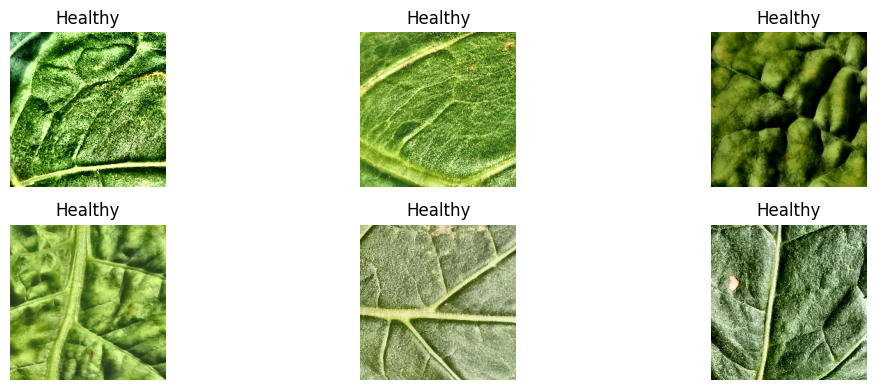

In [ ]:
# Cell 7: Data Generators and Augmentation
# ===============================================

def preprocess_image(path, label, augment=False):
    """Preprocess single image with memory management"""
    try:
        # Read and decode image
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.cast(img, tf.float32)
        img.set_shape([None, None, 3])

        # Resize and normalize
        img = tf.image.resize(img, CONFIG['IMG_SIZE'])
        img = img / 255.0

        # Apply augmentation if specified
        if augment:
            # Random horizontal flip
            img = tf.image.random_flip_left_right(img)
            # Random brightness
            img = tf.image.random_brightness(img, 0.2)
            # Random contrast
            img = tf.image.random_contrast(img, 0.8, 1.2)
            # Random rotation (simplified)
            img = tf.image.rot90(img, tf.random.uniform([], 0, 4, dtype=tf.int32))

        return img, label
    except:
        # Return zero tensor on error
        return tf.zeros([*CONFIG['IMG_SIZE'], 3], dtype=tf.float32), label

def create_dataset(paths, labels, augment=False, batch_size=None):
    """Create TensorFlow dataset with efficient loading"""
    if batch_size is None:
        batch_size = CONFIG['BATCH_SIZE']

    if paths is None or len(paths) == 0:
        return None

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    # Map preprocessing
    dataset = dataset.map(
        lambda x, y: preprocess_image(x, y, augment=augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Shuffle if augmenting (training)
    if augment:
        dataset = dataset.shuffle(min(1000, len(paths)))

    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create datasets
if X_train is not None:
    print("🔄 Creating datasets...")

    train_dataset = create_dataset(X_train, y_train, augment=True)
    val_dataset = create_dataset(X_val, y_val, augment=False)
    test_dataset = create_dataset(X_test, y_test, augment=False)

    print("✅ Datasets created successfully!")

    # Visualize a few samples
    print("\n🖼️ Sample data visualization:")
    plt.figure(figsize=(12, 4))

    for i, (images, labels) in enumerate(train_dataset.take(1)):
        for j in range(min(6, images.shape[0])):
            plt.subplot(2, 3, j+1)
            plt.imshow(images[j])
            plt.title(f"{'Diseased' if labels[j] == 1 else 'Healthy'}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("❌ No training data available for dataset creation")
    train_dataset = val_dataset = test_dataset = None

In [ ]:
# Cell 8: Model Architecture
# ===============================================

def build_tobacco_model(input_shape=(224, 224, 3)):
    """Build lightweight ResNet50-based model for tobacco leaf classification"""

    # Base model (frozen initially)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    # Add custom classifier
    inputs = base_model.input
    x = base_model.output

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Dense layers with dropout
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='predictions')(x)

    # Create model
    model = Model(inputs, outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

def create_callbacks():
    """Create training callbacks"""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=CONFIG['PATIENCE'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    return callbacks

# Build model
if train_dataset is not None:
    print("🏗️ Building tobacco leaf disease classification model...")

    model, base_model = build_tobacco_model()

    print(f"✅ Model built successfully!")
    print(f"📊 Total parameters: {model.count_params():,}")
    print(f"🔒 Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

    # Display model summary (compact)
    model.summary()

else:
    print("❌ No training data available for model building")
    model = base_model = None

🏗️ Building tobacco leaf disease classification model...
✅ Model built successfully!
📊 Total parameters: 24,137,985
🔒 Trainable parameters: 545,665


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,137,985 (92.08 MB)

 Trainable params: 545,665 (2.08 MB)

 Non-trainable params: 23,592,320 (90.00 MB)

🔥 Training tobacco leaf disease classification model...
🚀 Starting model training...

📚 Phase 1: Training with frozen base model...
Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.9107 - loss: 0.6676 - val_accuracy: 0.9524 - val_loss: 0.4585 - learning_rate: 0.0010
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.9416 - loss: 0.4795 - val_accuracy: 0.9524 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9467 - loss: 0.4301 - val_accuracy: 0.9524 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9466 - loss: 0.4182 - val_accuracy: 0.9524 - val_loss: 0.4014 - learning_rate: 0.0010
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9478 - loss: 0.3999 - val_accuracy: 0.9562 - val_loss: 0.3356 - learning_rate: 0.0010
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9451 - loss: 0.3667 - val_acc

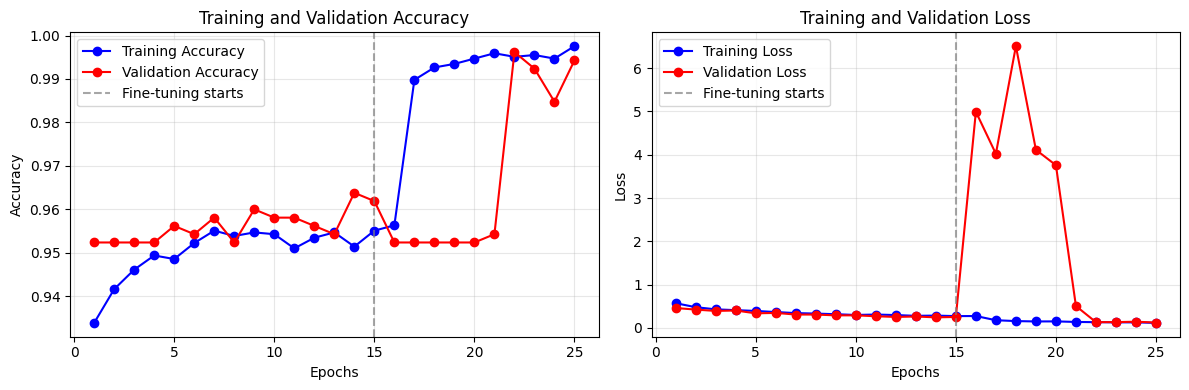

💾 Model saved to: /content/tobacco_classification/models/tobacco_model.h5


In [ ]:
# Cell 9: Model Training
# ===============================================

def train_model(model, base_model, train_ds, val_ds):
    """Train the tobacco leaf disease model"""

    print("🚀 Starting model training...")

    # Phase 1: Train with frozen base
    print("\n📚 Phase 1: Training with frozen base model...")
    callbacks = create_callbacks()

    history1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=CONFIG['EPOCHS'],
        callbacks=callbacks,
        verbose=1
    )

    # Phase 2: Fine-tuning
    print("\n🎯 Phase 2: Fine-tuning...")

    # Unfreeze base model
    base_model.trainable = True

    # Use lower learning rate for fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['FINE_TUNE_LR']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    callbacks_fine = create_callbacks()

    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=CONFIG['FINE_TUNE_EPOCHS'],
        callbacks=callbacks_fine,
        verbose=1
    )

    return history1, history2

def plot_training_history(history1, history2):
    """Plot training history"""

    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs = range(1, len(acc) + 1)
    phase1_end = len(history1.history['accuracy'])

    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.7,
                label='Fine-tuning starts')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.7,
                label='Fine-tuning starts')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Train the model
if model is not None and train_dataset is not None:

    # Clear any existing models from memory
    tf.keras.backend.clear_session()
    gc.collect()

    print("🔥 Training tobacco leaf disease classification model...")

    history1, history2 = train_model(model, base_model, train_dataset, val_dataset)

    print("✅ Training completed!")

    # Plot training history
    plot_training_history(history1, history2)

    # Save model
    model_path = os.path.join(PATHS['MODELS_DIR'], 'tobacco_model.h5')
    model.save(model_path)
    print(f"💾 Model saved to: {model_path}")

else:
    print("❌ Cannot train model - missing model or data")
    history1 = history2 = None

📊 Evaluating trained model...

🔍 Evaluating model on Validation set...

📊 Validation Results:
   🎯 Accuracy:  0.9943
   🎯 Precision: 0.9583
   🎯 Recall:    0.9200
   🎯 F1-Score:  0.9388
   🎯 ROC-AUC:   0.9994

📋 Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       500
    Diseased       0.96      0.92      0.94        25

    accuracy                           0.99       525
   macro avg       0.98      0.96      0.97       525
weighted avg       0.99      0.99      0.99       525



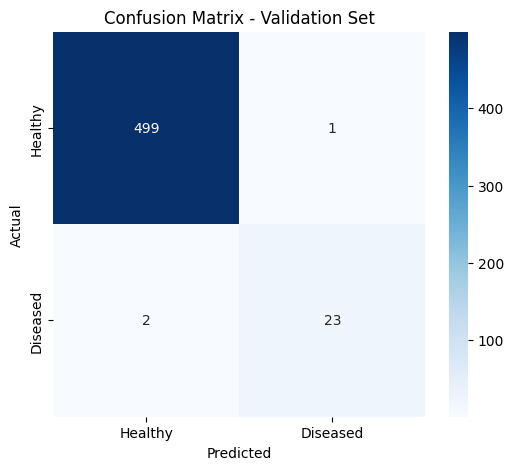


🔍 Evaluating model on Test set...

📊 Test Results:
   🎯 Accuracy:  0.9981
   🎯 Precision: 1.0000
   🎯 Recall:    0.9600
   🎯 F1-Score:  0.9796
   🎯 ROC-AUC:   0.9999

📋 Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       500
    Diseased       1.00      0.96      0.98        25

    accuracy                           1.00       525
   macro avg       1.00      0.98      0.99       525
weighted avg       1.00      1.00      1.00       525



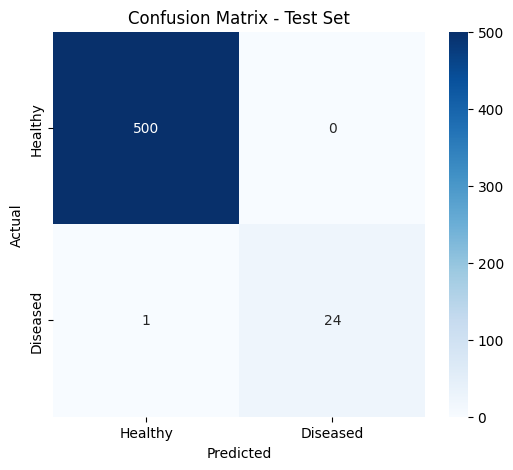


🔍 Testing prediction on sample image...


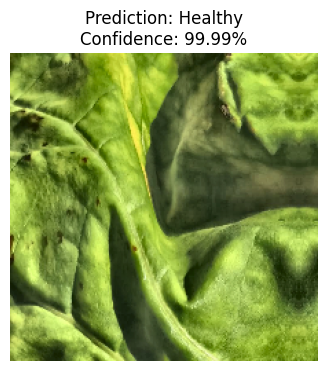

🔍 Prediction: Healthy (Confidence: 99.99%)
✅ Model evaluation completed!


In [ ]:
# Cell 10: Model Evaluation
# ===============================================

from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(model, dataset, dataset_name="Test"):
    """Evaluate model performance"""

    print(f"\n🔍 Evaluating model on {dataset_name} set...")

    y_true = []
    y_pred_proba = []
    y_pred = []

    # Collect predictions
    for images, labels in dataset:
        preds = model.predict(images, verbose=0).flatten()
        y_true.extend(labels.numpy())
        y_pred_proba.extend(preds)
        y_pred.extend((preds > 0.5).astype(int))

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred_proba)
    except:
        auc = 0.0

    print(f"\n📊 {dataset_name} Results:")
    print(f"   🎯 Accuracy:  {accuracy:.4f}")
    print(f"   🎯 Precision: {precision:.4f}")
    print(f"   🎯 Recall:    {recall:.4f}")
    print(f"   🎯 F1-Score:  {f1:.4f}")
    print(f"   🎯 ROC-AUC:   {auc:.4f}")

    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_true, y_pred,
                              target_names=['Healthy', 'Diseased'],
                              zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Healthy', 'Diseased'],
                yticklabels=['Healthy', 'Diseased'])
    plt.title(f'Confusion Matrix - {dataset_name} Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc
    }

def predict_single_image(model, image_path):
    """Predict disease on a single image"""
    try:
        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(
            image_path, target_size=CONFIG['IMG_SIZE'][:2]
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) / 255.0

        # Make prediction
        prediction = model.predict(img_array, verbose=0)[0][0]
        predicted_class = 'Diseased' if prediction > 0.5 else 'Healthy'
        confidence = prediction if prediction > 0.5 else 1 - prediction

        # Display result
        plt.figure(figsize=(6, 4))
        plt.imshow(img)
        plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2%}')
        plt.axis('off')
        plt.show()

        print(f"🔍 Prediction: {predicted_class} (Confidence: {confidence:.2%})")

        return predicted_class, confidence

    except Exception as e:
        print(f"❌ Error predicting image: {e}")
        return None, None

# Evaluate the model
if model is not None and val_dataset is not None:

    print("📊 Evaluating trained model...")

    # Evaluate on validation set
    val_metrics = evaluate_model(model, val_dataset, "Validation")

    # Evaluate on test set if available
    if test_dataset is not None:
        test_metrics = evaluate_model(model, test_dataset, "Test")

    # Test prediction on a sample image
    if X_test is not None and len(X_test) > 0:
        print("\n🔍 Testing prediction on sample image...")
        sample_image = X_test[0]
        predict_single_image(model, sample_image)

    print("✅ Model evaluation completed!")

else:
    print("❌ Cannot evaluate model - missing model or data")

In [ ]:
# Cell 11: Final Summary and Results
# ===============================================

import json
from datetime import datetime

def save_results(metrics, config, model_path):
    """Save training results and configuration"""

    results = {
        'timestamp': datetime.now().isoformat(),
        'model_path': model_path,
        'config': config,
        'metrics': metrics,
        'data_info': {
            'total_images': len(X_paths) if 'X_paths' in globals() and X_paths is not None else 0,
            'train_images': len(X_train) if 'X_train' in globals() and X_train is not None else 0,
            'val_images': len(X_val) if 'X_val' in globals() and X_val is not None else 0,
            'test_images': len(X_test) if 'X_test' in globals() and X_test is not None else 0
        }
    }

    # Save results
    results_path = os.path.join(PATHS['RESULTS_DIR'], 'training_results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"💾 Results saved to: {results_path}")
    return results_path

def print_final_summary():
    """Print comprehensive project summary"""

    print("\n" + "="*80)
    print("🌿 TOBACCO LEAF DISEASE CLASSIFICATION - FINAL SUMMARY")
    print("="*80)

    print("\n📋 Project Overview:")
    print("   • Task: Binary classification (Healthy vs Diseased tobacco leaves)")
    print("   • Model: ResNet50-based transfer learning")
    print("   • Framework: TensorFlow/Keras")
    print("   • Environment: Google Colab")

    if 'X_paths' in globals() and X_paths is not None:
        healthy_count = np.sum(y_labels == 0) if 'y_labels' in globals() else 0
        diseased_count = np.sum(y_labels == 1) if 'y_labels' in globals() else 0

        print(f"\n📊 Dataset Statistics:")
        print(f"   • Total images: {len(X_paths)}")
        print(f"   • Healthy leaves: {healthy_count}")
        print(f"   • Diseased leaves: {diseased_count}")
        print(f"   • Class balance: {healthy_count/(len(X_paths))*100:.1f}% healthy")

    print(f"\n🏗️ Model Configuration:")
    print(f"   • Architecture: ResNet50 + Custom Classifier")
    print(f"   • Input size: {CONFIG['IMG_SIZE']}")
    print(f"   • Batch size: {CONFIG['BATCH_SIZE']}")
    print(f"   • Training epochs: {CONFIG['EPOCHS']}")
    print(f"   • Fine-tuning epochs: {CONFIG['FINE_TUNE_EPOCHS']}")+++++

    print(f"\n🔧 Key Features:")
    print("   ✅ Memory-efficient file handling")
    print("   ✅ Data augmentation for improved generalization")
    print("   ✅ Transfer learning with ResNet50")
    print("   ✅ Two-phase training (frozen + fine-tuning)")
    print("   ✅ Comprehensive evaluation metrics")
    print("   ✅ Colab-optimized implementation")

    if 'val_metrics' in globals():
        print(f"\n🎯 Model Performance:")
        print(f"   • Validation Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"   • Validation F1-Score: {val_metrics['f1_score']:.4f}")
        print(f"   • Validation ROC-AUC: {val_metrics['roc_auc']:.4f}")

    print(f"\n💾 Output Files:")
    print(f"   • Model: {PATHS['MODELS_DIR']}/tobacco_model.h5")
    print(f"   • Results: {PATHS['RESULTS_DIR']}/training_results.json")

    print("\n" + "="*80)
    print("🎉 TOBACCO LEAF DISEASE CLASSIFICATION COMPLETED!")
    print("="*80)

# Save results and print summary
if 'val_metrics' in globals() and 'model' in globals():

    # Prepare metrics for saving
    save_metrics = {'validation': val_metrics}
    if 'test_metrics' in globals():
        save_metrics['test'] = test_metrics

    # Save results
    model_path = os.path.join(PATHS['MODELS_DIR'], 'tobacco_model.h5')
    results_path = save_results(save_metrics, CONFIG, model_path)

    # Print final summary
    print_final_summary()

    # Memory cleanup
    tf.keras.backend.clear_session()
    gc.collect()

    print("\n✅ All operations completed successfully!")

else:
    print("⚠️ Training not completed - unable to generate full summary")

# Display file structure
print(f"\n📁 Generated File Structure:")
for root, dirs, files in os.walk(PATHS['BASE_DIR']):
    level = root.replace(PATHS['BASE_DIR'], '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files)-5} more files")

💾 Results saved to: /content/tobacco_classification/results/training_results.json

🌿 TOBACCO LEAF DISEASE CLASSIFICATION - FINAL SUMMARY

📋 Project Overview:
   • Task: Binary classification (Healthy vs Diseased tobacco leaves)
   • Model: ResNet50-based transfer learning
   • Framework: TensorFlow/Keras
   • Environment: Google Colab

📊 Dataset Statistics:
   • Total images: 3500
   • Healthy leaves: 3331
   • Diseased leaves: 169
   • Class balance: 95.2% healthy

🏗️ Model Configuration:
   • Architecture: ResNet50 + Custom Classifier
   • Input size: (224, 224)
   • Batch size: 16
   • Training epochs: 15
   • Fine-tuning epochs: 10

🔧 Key Features:
   ✅ Memory-efficient file handling
   ✅ Data augmentation for improved generalization
   ✅ Transfer learning with ResNet50
   ✅ Two-phase training (frozen + fine-tuning)
   ✅ Comprehensive evaluation metrics
   ✅ Colab-optimized implementation

🎯 Model Performance:
   • Validation Accuracy: 0.9943
   • Validation F1-Score: 0.9388
   • V

✅ Model loaded from: /content/tobacco_classification/models/tobacco_model.h5

🧪 Testing loaded model...

🔍 Testing on validation images...


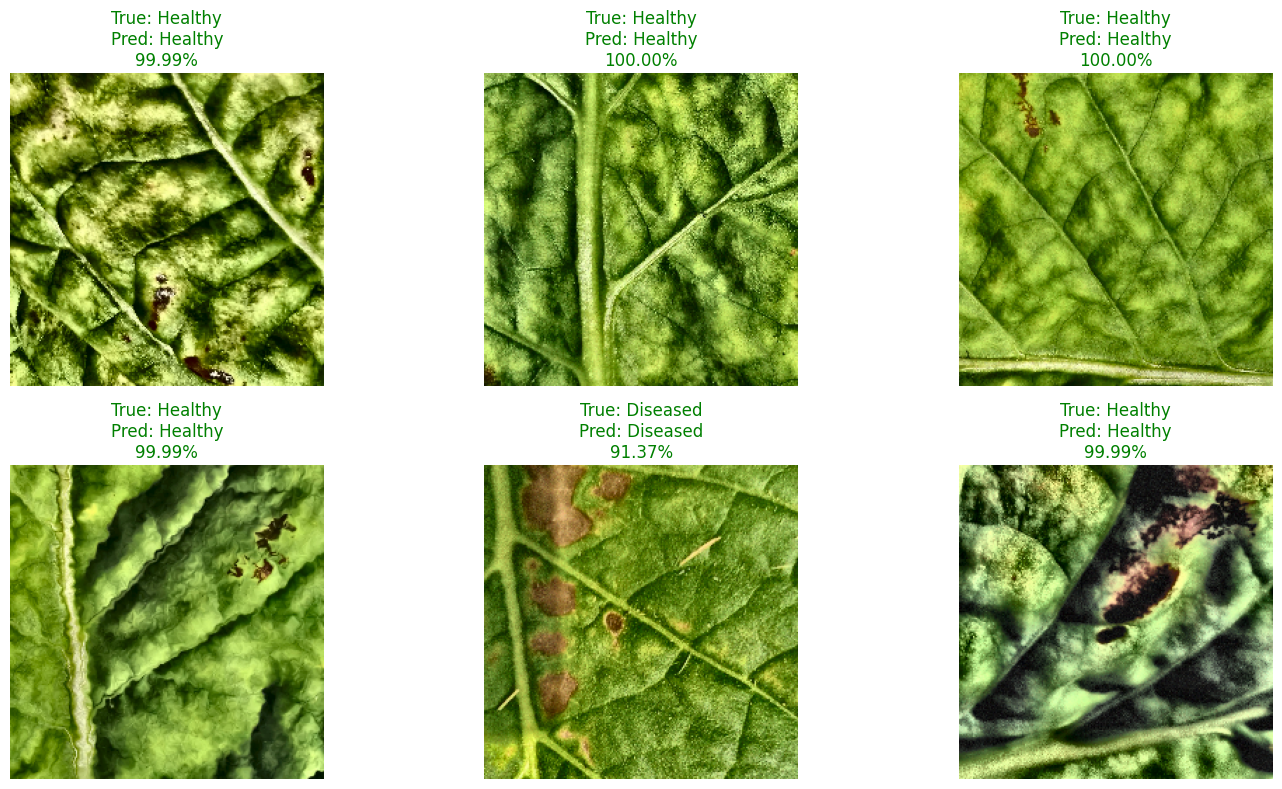


🌿 Testing on healthy leaf samples:
🔍 Predicting on 5 images...


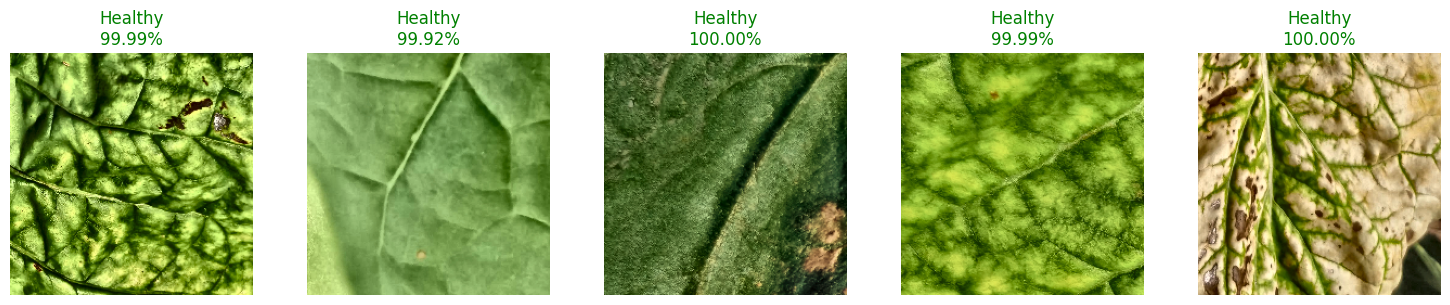


🦠 Testing on diseased leaf samples:
🔍 Predicting on 5 images...


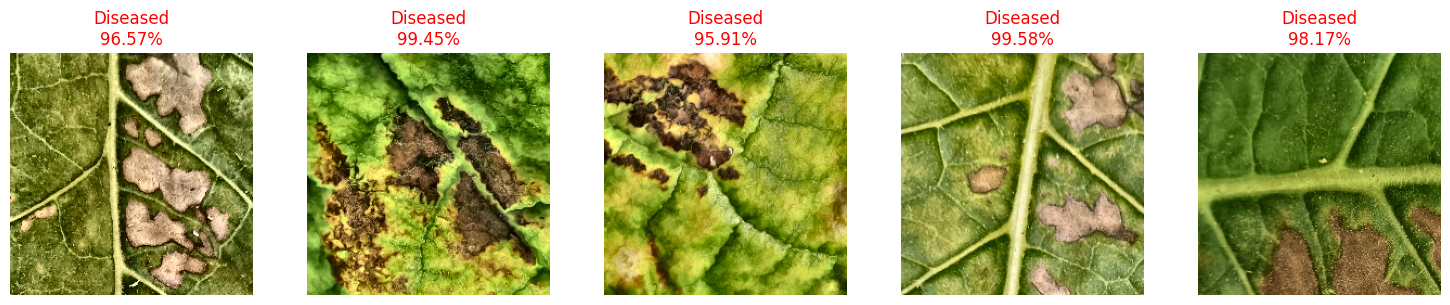


✅ Model testing completed!

💡 You can use the 'predict_leaf(image_path)' function to predict on new images!


In [ ]:
# Cell 12: Bonus - Load and Test Saved Model
# ===============================================

def load_saved_model(model_path):
    """Load previously saved model"""
    try:
        if os.path.exists(model_path):
            loaded_model = tf.keras.models.load_model(model_path)
            print(f"✅ Model loaded from: {model_path}")
            return loaded_model
        else:
            print(f"❌ Model file not found: {model_path}")
            return None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

def batch_predict_images(model, image_folder, max_images=10):
    """Predict on multiple images from a folder"""

    if not os.path.exists(image_folder):
        print(f"❌ Folder not found: {image_folder}")
        return

    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:max_images]

    if not image_files:
        print(f"❌ No images found in {image_folder}")
        return

    print(f"🔍 Predicting on {len(image_files)} images...")

    plt.figure(figsize=(15, 3 * ((len(image_files) + 4) // 5)))

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(image_folder, img_file)

        try:
            # Load and preprocess
            img = tf.keras.preprocessing.image.load_img(
                img_path, target_size=CONFIG['IMG_SIZE'][:2])
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0) / 255.0

            # Predict
            pred = model.predict(img_array, verbose=0)[0][0]
            class_name = 'Diseased' if pred > 0.5 else 'Healthy'
            confidence = pred if pred > 0.5 else 1 - pred

            # Plot
            plt.subplot((len(image_files) + 4) // 5, 5, i + 1)
            plt.imshow(img)
            plt.title(f'{class_name}\n{confidence:.2%}',
                     color='red' if class_name == 'Diseased' else 'green')
            plt.axis('off')

        except Exception as e:
            print(f"❌ Error processing {img_file}: {e}")

    plt.tight_layout()
    plt.show()

def create_prediction_function(model):
    """Create a simple prediction function"""

    def predict_tobacco_leaf(image_path_or_array):
        """
        Predict if a tobacco leaf is healthy or diseased

        Args:
            image_path_or_array: Path to image file or numpy array

        Returns:
            dict: Prediction results
        """
        try:
            if isinstance(image_path_or_array, str):
                # Load from file
                img = tf.keras.preprocessing.image.load_img(
                    image_path_or_array, target_size=CONFIG['IMG_SIZE'][:2])
                img_array = tf.keras.preprocessing.image.img_to_array(img)
            else:
                # Use provided array
                img_array = image_path_or_array
                img = tf.keras.preprocessing.image.array_to_img(img_array)

            # Preprocess
            img_array = tf.expand_dims(img_array, 0) / 255.0

            # Predict
            pred = model.predict(img_array, verbose=0)[0][0]

            result = {
                'prediction': 'Diseased' if pred > 0.5 else 'Healthy',
                'confidence': float(pred if pred > 0.5 else 1 - pred),
                'disease_probability': float(pred),
                'healthy_probability': float(1 - pred)
            }

            return result

        except Exception as e:
            return {'error': str(e)}

    return predict_tobacco_leaf

# Load saved model if it exists
model_path = os.path.join(PATHS['MODELS_DIR'], 'tobacco_model.h5')
saved_model = load_saved_model(model_path)

if saved_model is not None:
    print("\n🧪 Testing loaded model...")

    # Create prediction function
    predict_leaf = create_prediction_function(saved_model)

    # Test on some validation images if available
    if 'X_val' in globals() and X_val is not None and len(X_val) > 0:
        print("\n🔍 Testing on validation images...")

        # Test a few random validation images
        test_indices = np.random.choice(len(X_val), min(6, len(X_val)), replace=False)

        plt.figure(figsize=(15, 8))
        for i, idx in enumerate(test_indices):
            img_path = X_val[idx]
            true_label = 'Diseased' if y_val[idx] == 1 else 'Healthy'

            # Make prediction
            result = predict_leaf(img_path)

            # Load image for display
            img = tf.keras.preprocessing.image.load_img(
                img_path, target_size=CONFIG['IMG_SIZE'][:2])

            # Plot
            plt.subplot(2, 3, i + 1)
            plt.imshow(img)

            if 'error' in result:
                plt.title(f'Error: {result["error"]}', color='orange')
            else:
                pred_label = result['prediction']
                confidence = result['confidence']
                color = 'green' if pred_label == true_label else 'red'

                plt.title(f'True: {true_label}\nPred: {pred_label}\n{confidence:.2%}',
                         color=color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Test batch prediction on healthy images
    healthy_folder = os.path.join(PATHS['FINAL_ROOT'], 'healthy')
    if os.path.exists(healthy_folder):
        print("\n🌿 Testing on healthy leaf samples:")
        batch_predict_images(saved_model, healthy_folder, max_images=5)

    # Test batch prediction on diseased images
    diseased_folder = os.path.join(PATHS['FINAL_ROOT'], 'diseased')
    if os.path.exists(diseased_folder):
        print("\n🦠 Testing on diseased leaf samples:")
        batch_predict_images(saved_model, diseased_folder, max_images=5)

    print("\n✅ Model testing completed!")
    print("\n💡 You can use the 'predict_leaf(image_path)' function to predict on new images!")

else:
    print("⚠️ No saved model found. Train the model first using previous cells.")